#**Installation**

In [ ]:
!pip install faiss-cpu


     |████████████████████████████████| 8.6 MB 16.6 MB/s 


#**Import liabraries**


In [ ]:
import os
import time

import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# from dataset_utils import *
# from mnist_model import *
# from adv_model import *
# from dknn_attack_v2 import DKNNAttackV2
# from dknn import DKNNL2
# from utils import *

import torch.nn.functional as F

import pickle

import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split


import faiss

from torch.distributions.normal import Normal

import logging
import torch.optim as optim


#**Faiss_utils**

In [ ]:

def swig_ptr_from_FloatTensor(x):
    assert x.is_contiguous()
    assert x.dtype == torch.float32
    return faiss.cast_integer_to_float_ptr(x.storage().data_ptr())


def swig_ptr_from_LongTensor(x):
    assert x.is_contiguous()
    assert x.dtype == torch.int64, 'dtype=%s' % x.dtype
    return faiss.cast_integer_to_long_ptr(x.storage().data_ptr())


def search_index_pytorch(index, x, k, D=None, I=None):
    """call the search function of an index with pytorch tensor I/O (CPU
    and GPU supported)"""
    assert x.is_contiguous()
    n, d = x.size()
    assert d == index.d

    if D is None:
        D = torch.empty((n, k), dtype=torch.float32, device=x.device)
    else:
        assert D.size() == (n, k)

    if I is None:
        I = torch.empty((n, k), dtype=torch.int64, device=x.device)
    else:
        assert I.size() == (n, k)
    torch.cuda.synchronize()
    xptr = swig_ptr_from_FloatTensor(x)
    Iptr = swig_ptr_from_LongTensor(I)
    Dptr = swig_ptr_from_FloatTensor(D)
    index.search_c(n, xptr, k, Dptr, Iptr)
    torch.cuda.synchronize()
    return D, I

#**Mnist_models**

In [ ]:
'''
Define MNIST models
'''

import copy
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal


class KNNModel(nn.Module):
    '''
    A Pytorch model that apply an identiy function to the input (i.e. output =
    input). It is used to simulate kNN on the input space so that it is
    compatible with attacks implemented for DkNN.
    '''

    def __init__(self):
        super(KNNModel, self).__init__()
        self.identity = nn.Identity()

    def forward(self, x):
        x = self.identity(x)
        return x


# ============================================================================ #


class BasicModel(nn.Module):

    def __init__(self, num_classes=10):
        super(BasicModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2, padding=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# ============================================================================ #


class BasicModelV2(nn.Module):

    def __init__(self, num_classes=10):
        super(BasicModelV2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu2(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


# ============================================================================ #


class ClassAuxVAE(nn.Module):

    def __init__(self, input_dim, num_classes=10, latent_dim=20):
        super(ClassAuxVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.input_dim_flat = 1
        for dim in input_dim:
            self.input_dim_flat *= dim
        self.en_conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.en_conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2, padding=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.en_conv3 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU(inplace=True)
        self.en_fc1 = nn.Linear(2048, 128)
        self.relu4 = nn.ReLU(inplace=True)
        self.en_mu = nn.Linear(128, latent_dim)
        self.en_logvar = nn.Linear(128, latent_dim)

        self.de_fc1 = nn.Linear(latent_dim, 128)
        self.de_fc2 = nn.Linear(128, self.input_dim_flat * 2)

        # TODO: experiment with different auxilary architecture
        self.ax_fc1 = nn.Linear(latent_dim, 128)
        self.ax_fc2 = nn.Linear(128, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def encode(self, x):
        x = self.relu1(self.en_conv1(x))
        x = self.relu2(self.en_conv2(x))
        x = self.relu3(self.en_conv3(x))
        x = x.view(x.size(0), -1)
        x = self.relu4(self.en_fc1(x))
        en_mu = self.en_mu(x)
        # TODO: use tanh activation on logvar if unstable
        # en_std = torch.exp(0.5 * x[:, self.latent_dim:])
        en_logvar = self.en_logvar(x)
        return en_mu, en_logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.de_fc1(z))
        x = self.de_fc2(x)
        de_mu = x[:, :self.input_dim_flat]
        # de_std = torch.exp(0.5 * x[:, self.input_dim_flat:])
        de_logvar = x[:, self.input_dim_flat:].tanh()
        out_dim = (z.size(0), ) + self.input_dim
        return de_mu.view(out_dim).sigmoid(), de_logvar.view(out_dim)

    def auxilary(self, z):
        x = F.relu(self.ax_fc1(z))
        x = self.ax_fc2(x)
        return x

    def forward(self, x):
        en_mu, en_logvar = self.encode(x)
        z = self.reparameterize(en_mu, en_logvar)
        de_mu, de_logvar = self.decode(z)
        y = self.auxilary(z)
        return en_mu, en_logvar, de_mu, de_logvar, y


# ============================================================================ #


class VAE2(nn.Module):

    def __init__(self, input_dim, num_classes=10, latent_dim=20):
        super(VAE2, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.input_dim_flat = 1
        for dim in input_dim:
            self.input_dim_flat *= dim
        self.en_conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.en_conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2, padding=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.en_conv3 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=0)
        # self.relu3 = nn.ReLU(inplace=True)
        self.relu3 = nn.ReLU()
        self.en_fc1 = nn.Linear(2048, 400)
        self.relu4 = nn.ReLU(inplace=True)
        self.en_mu = nn.Linear(400, latent_dim)
        self.en_logvar = nn.Linear(400, latent_dim)

        self.de_fc1 = nn.Linear(latent_dim, 400)
        self.de_relu1 = nn.ReLU(inplace=True)
        self.de_fc2 = nn.Linear(400, self.input_dim_flat)

    def encode(self, x):
        x = self.relu1(self.en_conv1(x))
        x = self.relu2(self.en_conv2(x))
        x = self.relu3(self.en_conv3(x))
        x = x.view(x.size(0), -1)
        x = self.relu4(self.en_fc1(x))
        en_mu = self.en_mu(x)
        # TODO: use tanh activation on logvar if unstable
        # en_std = torch.exp(0.5 * x[:, self.latent_dim:])
        en_logvar = self.en_logvar(x)
        return en_mu, en_logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.de_relu1(self.de_fc1(z))
        x = self.de_fc2(x)
        out_dim = (z.size(0), ) + self.input_dim
        return x.view(out_dim).sigmoid()

    def forward(self, x):
        en_mu, en_logvar = self.encode(x)
        z = self.reparameterize(en_mu, en_logvar)
        output = self.decode(z)
        return en_mu, en_logvar, output


# ============================================================================ #


class VAE(nn.Module):

    def __init__(self, input_dim, num_classes=10, latent_dim=20):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.input_dim_flat = 1
        for dim in input_dim:
            self.input_dim_flat *= dim
        self.en_fc1 = nn.Linear(self.input_dim_flat, 400)
        self.en_relu1 = nn.ReLU(inplace=True)
        self.en_fc2 = nn.Linear(400, 400)
        self.en_relu2 = nn.ReLU(inplace=True)
        self.en_mu = nn.Linear(400, latent_dim)
        self.en_logvar = nn.Linear(400, latent_dim)

        self.de_fc1 = nn.Linear(latent_dim, 400)
        self.de_relu1 = nn.ReLU(inplace=True)
        self.de_fc2 = nn.Linear(400, self.input_dim_flat)

    def encode(self, x):
        x = x.view(-1, self.input_dim_flat)
        x = self.en_relu1(self.en_fc1(x))
        x = self.en_relu2(self.en_fc2(x))
        en_mu = self.en_mu(x)
        # TODO: use tanh activation on logvar if unstable
        # en_std = torch.exp(0.5 * x[:, self.latent_dim:])
        en_logvar = self.en_logvar(x)
        return en_mu, en_logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.de_relu1(self.de_fc1(z))
        x = self.de_fc2(x)
        out_dim = (z.size(0), ) + self.input_dim
        return x.view(out_dim).sigmoid()

    def forward(self, x):
        en_mu, en_logvar = self.encode(x)
        z = self.reparameterize(en_mu, en_logvar)
        output = self.decode(z)
        return en_mu, en_logvar, output


# ============================================================================ #


class SNNLModel(nn.Module):

    def __init__(self, num_classes=10, train_it=False):
        super(SNNLModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2, padding=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(2048, num_classes)

        # initialize inverse temperature for each layer
        self.it = torch.nn.Parameter(
            data=torch.tensor([-4.6, -4.6, -4.6]), requires_grad=train_it)

        # set up hook to get representations
        self.layers = ['relu1', 'relu2', 'relu3']
        self.activations = {}
        for name, module in self.named_children():
            if name in self.layers:
                module.register_forward_hook(self._get_activation(name))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _get_activation(self, name):
        def hook(model, input, output):
            self.activations[name] = output
        return hook

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def loss_function(self, x, y_target, alpha=-1):
        """soft nearest neighbor loss"""
        snn_loss = torch.zeros(1).cuda()
        y_pred = self.forward(x)
        for l, layer in enumerate(self.layers):
            rep = self.activations[layer]
            rep = rep.view(x.size(0), -1)
            for i in range(x.size(0)):
                mask_same = (y_target[i] == y_target).type(torch.float32)
                mask_self = torch.ones(x.size(0)).cuda()
                mask_self[i] = 0
                dist = ((rep[i] - rep) ** 2).sum(1) * self.it[l].exp()
                # dist = ((rep[i] - rep) ** 2).sum(1) * 0.01
                # TODO: get nan gradients at
                # Function 'MulBackward0' returned nan values in its 1th output.
                exp = torch.exp(- torch.min(dist, torch.tensor(50.).cuda()))
                # exp = torch.exp(- dist)
                snn_loss += torch.log(torch.sum(mask_self * mask_same * exp) /
                                      torch.sum(mask_self * exp))

        ce_loss = F.cross_entropy(y_pred, y_target)
        return y_pred, ce_loss - alpha / x.size(0) * snn_loss


# ============================================================================ #


class HiddenMixupModel(nn.Module):

    def __init__(self, num_classes=10):
        super(HiddenMixupModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2, padding=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, target=None, mixup_hidden=False, mixup_alpha=0.1,
                layer_mix=None):

        if mixup_hidden:
            if layer_mix is None:
                # TODO: which layers?
                layer_mix = random.randint(0, 4)

            if layer_mix == 0:
                x, y_a, y_b, lam = self.mixup_data(x, target, mixup_alpha)
            x = self.conv1(x)
            x = self.relu1(x)

            if layer_mix == 1:
                x, y_a, y_b, lam = self.mixup_data(x, target, mixup_alpha)
            x = self.conv2(x)
            x = self.relu2(x)

            if layer_mix == 2:
                x, y_a, y_b, lam = self.mixup_data(x, target, mixup_alpha)
            x = self.conv3(x)
            x = self.relu3(x)

            if layer_mix == 3:
                x, y_a, y_b, lam = self.mixup_data(x, target, mixup_alpha)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            if layer_mix == 4:
                x, y_a, y_b, lam = self.mixup_data(x, target, mixup_alpha)

            # lam = torch.tensor(lam).cuda()
            # lam = lam.repeat(y_a.size())
            return x, y_a, y_b, lam

        else:
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.conv3(x)
            x = self.relu3(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x

    @staticmethod
    def loss_function(y_pred, y_a, y_b, lam):
        loss = lam * F.cross_entropy(y_pred, y_a) + \
            (1 - lam) * F.cross_entropy(y_pred, y_b)
        return loss

    @staticmethod
    def mixup_data(x, y, alpha):
        '''
        Compute the mixup data. Return mixed inputs, pairs of targets, and
        lambda. Code from
        https://github.com/vikasverma1077/manifold_mixup/blob/master/supervised/models/utils.py
        '''
        if alpha > 0.:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1.
        index = torch.randperm(x.size(0)).cuda()
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam


# ============================================================================ #


class Autoencoder(nn.Module):

    def __init__(self, input_dim, latent_dim=20):
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.input_dim_flat = 1
        for dim in input_dim:
            self.input_dim_flat *= dim
        self.conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2, padding=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(2048, 400)
        self.relu4 = nn.ReLU(inplace=True)
        self.latent = nn.Linear(400, latent_dim)

        self.de_fc1 = nn.Linear(latent_dim, 400)
        self.relu5 = nn.ReLU(inplace=True)
        self.de_fc2 = nn.Linear(400, self.input_dim_flat)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def encode(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.relu4(self.fc(x))
        x = self.latent(x)
        return x

    def decode(self, z):
        x = self.relu5(self.de_fc1(z))
        x = self.de_fc2(x)
        out_dim = (z.size(0), ) + self.input_dim
        return x.view(out_dim)

    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return z, out

    def loss_function(self, latent, x_recon, inputs, targets):
        # MSE loss
        return torch.sum((inputs - x_recon) ** 2)


# ============================================================================ #


class NCAModelV3(nn.Module):

    def __init__(self, normalize=False, output_dim=100, num_classes=10,
                 init_it=1e-2, train_it=False, train_data=None):
        super(NCAModelV3, self).__init__()
        self.normalize = normalize
        self.output_dim = output_dim
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2, padding=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc_ = nn.Linear(2048, output_dim)
        # self.fc = nn.Identity()
        self.fc = nn.Sigmoid()

        # initialize inverse temperature for each layer
        self.log_it = torch.nn.Parameter(
            data=torch.tensor(np.log(init_it)), requires_grad=train_it)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        self.train_data = train_data
        self.train_rep = None

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc_(x)
        if self.normalize:
            x = F.normalize(x, p=2, dim=1)
        x = self.fc(x)
        return x

    def forward_adv(self, x_orig, y_target, params):
        """
        """
        epsilon = params['epsilon']
        step_size = params['step_size']
        num_steps = params['num_steps']
        rand = params['random_start']

        # training samples that we want to query against should not be perturbed
        # so we keep an extra copy and detach it from gradient computation
        with torch.no_grad():
            outputs_orig = self.forward(x_orig).detach()

        x = x_orig.clone()
        if rand:
            noise = torch.zeros_like(x).normal_(0, 1).view(x.size(0), -1)
            x += noise.renorm(2, 0, epsilon).view(x.size())

        for _ in range(num_steps):
            x.requires_grad_()
            with torch.enable_grad():
                outputs = self.forward(x)
                p_target = self.get_prob(
                    outputs, y_target, x_orig=outputs_orig)
                loss = - torch.log(p_target).sum()
            grad = torch.autograd.grad(loss, x)[0].detach()
            grad_norm = grad.view(x.size(0), -1).norm(2, 1).clamp(1e-5, 1e9)
            delta = step_size * grad / grad_norm.view(x.size(0), 1, 1, 1)
            x = x.detach() + delta
            diff = (x - x_orig).view(x.size(0), -1).renorm(2, 0, epsilon)
            x = diff.view(x.size()) + x_orig
            x.clamp_(0, 1)

        return outputs_orig, self.forward(x)

    def get_prob(self, x, y_target, x_orig=None):
        """
        If x_orig is given, compute distance w.r.t. x_orig instead of samples
        in the same batch (x). It is intended to be used with adversarial
        training.
        """
        if x_orig is not None:
            assert x.size(0) == x_orig.size(0)

        batch_size = x.size(0)
        device = x.device
        x = x.view(batch_size, -1)
        if x_orig is not None:
            x_orig = x_orig.view(batch_size, -1)
            x_repeat = x_orig.repeat(batch_size, 1, 1).transpose(0, 1)
        else:
            x_repeat = x.repeat(batch_size, 1, 1).transpose(0, 1)
        dist = ((x_repeat - x) ** 2).sum(2) * self.log_it.exp()
        exp = torch.exp(- dist.clamp(- 50, 50))
        mask_not_self = 1 - torch.eye(batch_size, device=device)
        mask_same = (y_target.repeat(batch_size, 1).transpose(0, 1) ==
                     y_target).float()
        p_target = ((mask_not_self * mask_same * exp).sum(0) /
                    (mask_not_self * exp).sum(0))
        # p_target = (mask_same * exp).sum(0) / exp.sum(0)
        # Prevent the case where there's only one sample in the batch from a
        # certain clss, resulting in p_target being 0
        p_target = torch.max(p_target, torch.tensor(1e-30).to(device))

        return p_target

    def loss_function(self, output, y_target, orig=None):
        """soft nearest neighbor loss"""
        p_target = self.get_prob(output, y_target, x_orig=orig)
        # y_pred = p_target.max(1)
        loss = - torch.log(p_target)
        return loss.mean()


    def get_train_rep(self, batch_size=200, requires_grad=False):
        """update self.train_rep by running it through the current model"""
        if self.train_data is None:
            raise ValueError(
                'Cannot compute train rep as train data is not provided.')
        x_train, _ = self.train_data
        device = self._get_device()
        train_rep = torch.zeros((x_train.size(0), self.output_dim),
                                device=device, requires_grad=requires_grad)
        num_batches = np.ceil(x_train.size(0) // batch_size).astype(np.int32)
        with torch.set_grad_enabled(requires_grad):
            for i in range(num_batches):
                start = i * batch_size
                end = (i + 1) * batch_size
                train_rep[start:end] = self.forward(
                    x_train[start:end].to(device))
        return train_rep

    def recompute_train_rep(self):
        self.train_rep = self.get_train_rep(requires_grad=False)

    def compute_logits(self, x, recompute_train_rep=False, requires_grad=False,
                       from_outputs=False):

        if recompute_train_rep:
            self.recompute_train_rep()
        _, y_train = self.train_data
        device = self._get_device()
        # logits = torch.zeros((x.size(0), self.num_classes), device=x.device,
        #                      requires_grad=requires_grad)
        logits = []
        with torch.set_grad_enabled(requires_grad):
            if not from_outputs:
                rep = self.forward(x.to(device))
            else:
                rep = x
            dist = ((self.train_rep - rep.unsqueeze(1)) ** 2).sum(2)
            exp = torch.exp(- dist.clamp(- 50, 50) * self.log_it.exp())
            for j in range(self.num_classes):
                mask_j = (y_train == j).float().to(device)
                logits.append(
                    ((mask_j * exp).sum(1) / exp.sum(1)).unsqueeze(-1))
        return torch.cat(logits, dim=-1)

    def _get_device(self):
        return next(self.parameters()).device


class WeightedNCA(NCAModelV3):
    def __init__(self, normalize=False, output_dim=100, num_classes=10,
                 init_it=1e-2, train_it=False, train_data=None):
        super().__init__(normalize=normalize, output_dim=output_dim,
                         num_classes=num_classes, init_it=init_it,
                         train_it=train_it, train_data=train_data)
        self.weights = torch.nn.Parameter(
            data=torch.ones(len(self.train_data[0])), requires_grad=True)

    def compute_logits(self, x, recompute_train_rep=False, requires_grad=False,
                       from_outputs=False):

        if recompute_train_rep:
            self.recompute_train_rep()
        _, y_train = self.train_data
        device = self._get_device()
        
        logits = []
        with torch.set_grad_enabled(requires_grad):
            if not from_outputs:
                rep = self.forward(x.to(device))
            else:
                rep = x
            dist = ((self.train_rep - rep.unsqueeze(1)) ** 2).sum(2)
            exp = torch.exp(- dist.clamp(- 50, 50) * self.log_it.exp())
            exp *= self.weights.sigmoid()
            for j in range(self.num_classes):
                mask_j = (y_train == j).float().to(device)
                logits.append(
                    ((mask_j * exp).sum(1) / exp.sum(1)).unsqueeze(-1))
        return torch.cat(logits, dim=-1)


class SoftLabelNCA(NCAModelV3):
    def __init__(self, ys_train, normalize=False, output_dim=100, num_classes=10,
                 init_it=1e-2, train_it=False, train_data=None):
        super().__init__(normalize=normalize, output_dim=output_dim,
                         num_classes=num_classes, init_it=init_it,
                         train_it=train_it, train_data=train_data)
        self.ys_train = ys_train

    def recompute_ys_train(self, k):
        self.recompute_train_rep()
        y_train = self.train_data[1]
        for i in range(len(y_train)):
            dist = ((self.train_rep[i] - self.train_rep) ** 2).sum(1)
            nb = torch.topk(dist, k, largest=False)[1]
            ys = np.bincount(
                y_train[nb].numpy(), minlength=self.num_classes) / k
            self.ys_train[i] = torch.tensor(ys, device='cuda').float()

    def compute_logits(self, x, recompute_train_rep=False, requires_grad=False,
                       from_outputs=False):

        if recompute_train_rep:
            self.recompute_train_rep()
        _, y_train = self.train_data
        device = self._get_device()
        # logits = torch.zeros((x.size(0), self.num_classes), device=x.device,
        #                      requires_grad=requires_grad)
        logits = []
        with torch.set_grad_enabled(requires_grad):
            if not from_outputs:
                rep = self.forward(x.to(device))
            else:
                rep = x
            dist = ((self.train_rep - rep.unsqueeze(1)) ** 2).sum(2)
            exp = torch.exp(- (dist * self.log_it.exp()).clamp(- 50, 50))
            probs = exp @ self.ys_train
            logits = probs / exp.sum(1).unsqueeze(1)
        return logits

#**Dataset_utils**


In [ ]:
def rotate_img(img, rot):
    if rot == 0:  # 0 degrees rotation
        return img
    elif rot == 90:  # 90 degrees rotation
        return np.flipud(np.transpose(img, (1, 0, 2)))
    elif rot == 180:  # 90 degrees rotation
        return np.fliplr(np.flipud(img))
    elif rot == 270:  # 270 degrees rotation / or -90
        return np.transpose(np.flipud(img), (1, 0, 2))
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class RotateDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]
        rotated_imgs = [
            self.transform(img),
            self.transform(rotate_img(img, 90).copy()),
            self.transform(rotate_img(img, 180).copy()),
            self.transform(rotate_img(img, 270).copy())
        ]
        rotation_labels = torch.LongTensor([0, 1, 2, 3])
        return torch.stack(rotated_imgs, dim=0), rotation_labels


def load_mnist(batch_size,
               data_dir='./data',
               val_size=0.1,
               shuffle=True,
               seed=1):
    """Load MNIST data into train/val/test data loader"""

    num_workers = 4

    (x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
        data_dir=data_dir, val_size=val_size, shuffle=shuffle, seed=seed)

    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    validset = torch.utils.data.TensorDataset(x_valid, y_valid)
    testset = torch.utils.data.TensorDataset(x_test, y_test)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validloader = torch.utils.data.DataLoader(
        validset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return trainloader, validloader, testloader


def load_mnist_all(data_dir='./data', val_size=0.1, shuffle=True, seed=1):
    """Load entire MNIST dataset into tensor"""

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.MNIST(
        root=data_dir, train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(
        root=data_dir, train=False, download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=len(trainset), shuffle=False)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=len(testset), shuffle=False)

    x, y = next(iter(trainloader))
    x_test, y_test = next(iter(testloader))

    if val_size > 0:
        np.random.seed(seed)
        x_train, x_valid, y_train, y_valid = train_test_split(
            x.numpy(), y.numpy(), test_size=val_size, shuffle=shuffle,
            random_state=seed, stratify=y)
        return ((torch.tensor(x_train), torch.tensor(y_train)),
                (torch.tensor(x_valid), torch.tensor(y_valid)),
                (x_test, y_test))
    else:
        return ((x, y), (None, None), (x_test, y_test))


def load_mnist_rot(batch_size, data_dir='./data', val_size=0.1, shuffle=True,
                   seed=1):

    (x_train, _), (x_valid, _), (x_test, _) = load_mnist_all(
        data_dir, val_size=val_size, seed=seed)

    traindataset = RotateDataset(x_train.numpy().transpose(0, 2, 3, 1))
    trainloader = torch.utils.data.DataLoader(
        traindataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)

    validdataset = RotateDataset(x_valid.numpy().transpose(0, 2, 3, 1))
    validloader = torch.utils.data.DataLoader(
        validdataset, batch_size=batch_size, shuffle=False, num_workers=4)

    testdataset = RotateDataset(x_test.numpy().transpose(0, 2, 3, 1))
    testloader = torch.utils.data.DataLoader(
        testdataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return trainloader, validloader, testloader


def load_cifar10(batch_size,
                 data_dir='./data',
                 val_size=0.1,
                 normalize=True,
                 augment=True,
                 shuffle=True,
                 seed=1):
    """Load CIFAR-10 data into train/val/test data loader"""

    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    num_workers = 4

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    if augment:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(
                5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
            transforms.ColorJitter(brightness=0.1),
            transforms.ToTensor()
        ])
    else:
        transform_train = transform

    if normalize:
        transform = transforms.Compose([
            transform,
            transforms.Normalize(mean, std)
        ])
        transform_train = transforms.Compose([
            transform_train,
            transforms.Normalize(mean, std)
        ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform_train)
    validset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    # Random split train and validation sets
    num_train = len(trainset)
    indices = list(range(num_train))
    split = int(np.floor(val_size * num_train))

    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers)
    validloader = torch.utils.data.DataLoader(
        validset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return trainloader, validloader, testloader


def load_cifar10_all(data_dir='./data', val_size=0.1, shuffle=True, seed=1):
    """Load entire CIFAR-10 dataset into tensor"""

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)
    validset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    # Random split train and validation sets
    num_train = len(trainset)
    indices = list(range(num_train))
    split = int(np.floor(val_size * num_train))

    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=(num_train - split), sampler=train_sampler)
    validloader = torch.utils.data.DataLoader(
        validset, batch_size=split, sampler=valid_sampler)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=len(testset), shuffle=False)

    x_train = next(iter(trainloader))
    x_valid = next(iter(validloader))
    x_test = next(iter(testloader))

    return x_train, x_valid, x_test


def load_cifar10_rot(batch_size, data_dir='./data', val_size=0.1, shuffle=True,
                     seed=1):

    (x_train, _), (x_valid, _), (x_test, _) = load_cifar10_all(
        data_dir, val_size=val_size, seed=seed)

    traindataset = RotateDataset(x_train.numpy().transpose(0, 2, 3, 1))
    trainloader = torch.utils.data.DataLoader(
        traindataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)

    validdataset = RotateDataset(x_valid.numpy().transpose(0, 2, 3, 1))
    validloader = torch.utils.data.DataLoader(
        validdataset, batch_size=batch_size, shuffle=False, num_workers=4)

    testdataset = RotateDataset(x_test.numpy().transpose(0, 2, 3, 1))
    testloader = torch.utils.data.DataLoader(
        testdataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return trainloader, validloader, testloader


def load_gtsrb(data_dir='./data', gray=False, train_file_name=None):
    """
    Load GTSRB data as a (datasize) x (channels) x (height) x (width) numpy
    matrix. Each pixel is rescaled to lie in [0,1].
    """

    def load_pickled_data(file, columns):
        """
        Loads pickled training and test data.
        Parameters
        ----------
        file : string
            Name of the pickle file.
        columns : list of str
            List of columns in pickled data we're interested in.
        Returns
        -------
        A tuple of datasets for given columns.
        """

        with open(file, mode='rb') as f:
            dataset = pickle.load(f)
        return tuple(map(lambda c: dataset[c], columns))

    def preprocess(x, gray):
        """
        Preprocess dataset: turn images into grayscale if specified, normalize
        input space to [0,1], reshape array to appropriate shape for NN model
        """

        if not gray:
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
        else:
            # Convert to grayscale, e.g. single Y channel
            x = 0.299 * x[:, :, :, 0] + 0.587 * x[:, :, :, 1] + \
                0.114 * x[:, :, :, 2]
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
            x = x[:, :, :, np.newaxis]
        return x

    # Load pickle dataset
    if train_file_name is None:
        x_train, y_train = load_pickled_data(
            data_dir + 'train.p', ['features', 'labels'])
    else:
        x_train, y_train = load_pickled_data(
            data_dir + train_file_name, ['features', 'labels'])
    x_val, y_val = load_pickled_data(
        data_dir + 'valid.p', ['features', 'labels'])
    x_test, y_test = load_pickled_data(
        data_dir + 'test.p', ['features', 'labels'])

    # Preprocess loaded data
    x_train = preprocess(x_train, gray)
    x_val = preprocess(x_val, gray)
    x_test = preprocess(x_test, gray)
    return x_train, y_train, x_val, y_val, x_test, y_test


class GtsrbDataset(torch.utils.data.Dataset):

    def __init__(self, x_np, y_np, mean=None, std=None, augment=False):

        self.x_pil = [Image.fromarray(
            (x * 255).astype(np.uint8)) for x in x_np]
        self.y_np = y_np.astype(np.int64)

        if mean is None:
            mean = (0, 0, 0)
            std = (1, 1, 1)

        if augment:
            self.transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4, padding_mode='edge'),
                transforms.RandomAffine(
                    5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
                transforms.ColorJitter(brightness=0.1),
                transforms.ToTensor(),
                # transforms.Normalize(mean, std),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                # transforms.Normalize(mean, std),
            ])

    def __getitem__(self, index):
        # apply the transformations and return tensors
        return self.transform(self.x_pil[index]), self.y_np[index]

    def __len__(self):
        return len(self.x_pil)


def load_gtsrb_dataloader(data_dir, batch_size, num_workers=4):

    x_train, y_train, x_val, y_val, x_test, y_test = load_gtsrb(
        data_dir=data_dir)

    # Standardization
    mean = np.mean(x_train, (0, 1, 2))
    std = np.std(x_train, (0, 1, 2))

    trainset = GtsrbDataset(x_train, y_train, mean, std, augment=True)
    validset = GtsrbDataset(x_val, y_val, mean, std, augment=False)
    testset = GtsrbDataset(x_test, y_test, mean, std, augment=False)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validloader = torch.utils.data.DataLoader(
        validset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return trainloader, validloader, testloader

# **DKNN**

In [ ]:
'''
Define Deep k-Nearest Neighbor object
'''


class DKNNL2(object):
    """
    An object that we use to create and store a deep k-nearest neighbor (DkNN)
    that uses Euclidean distance as a metric.
    """

    def __init__(self, model, x_train, y_train, x_cal, y_cal, layers, k=75,
                 num_classes=10, ys_train=None, cosine=False, device='cuda'):
        """
        Parameters
        ----------
        model : torch.nn.Module
            neural network model that extracts the representations
        x_train : torch.tensor
            a tensor of training samples with shape (num_train_samples, ) +
            input_shape
        y_train : torch.tensor
            a tensor of labels corresponding to samples in x_train with shape
            (num_train_samples, )
        x_cal : torch.tensor
            a tensor of calibrating samples used to calibrate credibility score
            as described in DkNN paper (Papernot & McDaniel '18)
        y_cal : torch.tensor
            a tensor of labels corresponding to x_cal
        layers : list of str
            a list of layer names that are used in DkNN
        k : int, optional
            the number of neighbors to consider, i.e. k in the kNN part
            (default is 75)
        num_classes : int, optional
            the number of classes (default is 10)
        ys_train : torch.tensor, optional
            specify soft labels for training samples. Must have shape
            (num_train_samples, num_classes). (default is None)
        cosine : bool, optional
            If True, use cosine distance. Else use Euclidean distance.
            (default is False)
        device : str, optional
            name of the device model is on (default is 'cuda')
        """
        self.model = model
        self.cosine = cosine
        self.x_train = x_train
        self.y_train = y_train
        self.ys_train = ys_train
        self.layers = layers
        self.k = k
        self.num_classes = num_classes
        self.device = device
        self.indices = []
        self.activations = {}

        # register hook to get representations
        layer_count = 0
        for name, module in self.model.named_children():
            # if layer name is one of the names specified in self.layers,
            # register a hook to extract the activation at every forward pass
            if name in self.layers:
                module.register_forward_hook(self._get_activation(name))
                layer_count += 1
        assert layer_count == len(layers)
        reps = self.get_activations(x_train, requires_grad=False)

        for layer in layers:
            # build faiss index from the activations by layer
            index = self._build_index(reps[layer].cpu())
            self.indices.append(index)

        # set up calibration for credibility score
        y_pred = self.classify(x_cal)
        self.A = np.zeros((x_cal.size(0), )) + self.k * len(self.layers)
        for i, (y_c, y_p) in enumerate(zip(y_cal, y_pred)):
            self.A[i] -= y_p[y_c]

    def _get_activation(self, name):
        """Hook used to get activation from specified layer name
        Parameters
        ----------
        name : str
            name of the layer to collect the activations
        Returns
        -------
        hook
            the hook function
        """
        def hook(model, input, output):
            self.activations[name] = output
        return hook

    def _build_index(self, xb):
        """Build faiss index from a given set of samples
        Parameters
        ----------
        xb : torch.tensor
            tensor of samples to build the search index, shape is
            (num_samples, dim)
        Returns
        -------
        index
            faiss index built on the given samples
        """

        d = xb.size(-1)
        # brute-force search on GPU (GPU generally doesn't have enough memory)
        # res = faiss.StandardGpuResources()
        # index = faiss.GpuIndexFlatIP(res, d)

        # brute-force search on CPU
        index = faiss.IndexFlatL2(d)

        index.add(xb.detach().cpu().numpy())
        return index

    def get_activations(self, x, batch_size=500, requires_grad=True,
                        device=None):
        """Get activations at each layer in self.layers
        Parameters
        ----------
        x : torch.tensor
            tensor of input samples, shape = (num_samples, ) + input_shape
        batch_size : int, optional
            batch size (Default is 500)
        requires_grad : bool, optional
            whether or not to require gradients on the activations
            (Default is False)
        device : str
            name of the device the model is on (Default is None)
        Returns
        -------
        activations : dict
            dict of torch.tensor containing activations
        """
        if device is None:
            device = self.device

        # first run through to set an empty tensor of an appropriate size
        with torch.no_grad():
            num_total = x.size(0)
            num_batches = int(np.ceil(num_total / batch_size))
            activations = {}
            self.model(x[0:1].to(device))
            for layer in self.layers:
                size = torch.tensor(self.activations[layer].size()[1:]).prod()
                activations[layer] = torch.empty((num_total, size),
                                                 dtype=torch.float32,
                                                 device=device,
                                                 requires_grad=False)

        with torch.set_grad_enabled(requires_grad):
            for i in range(num_batches):
                begin, end = i * batch_size, (i + 1) * batch_size
                # run a forward pass, the attribute self.activations get set
                # to activations of the current batch
                self.model(x[begin:end].to(device))
                # copy the extracted activations to the dictionary of
                # tensor allocated earlier
                for layer in self.layers:
                    act = self.activations[layer]
                    act = act.view(act.size(0), -1)
                    if self.cosine:
                        act = F.normalize(act, 2, 1)
                    activations[layer][begin:end] = act

            return activations

    def get_neighbors(self, x, k=None, layers=None):
        """Find k neighbors of x at specified layers
        Parameters
        ----------
        x : torch.tensor
            samples to query, shape (num_samples, ) + input_shape
        k : int, optional
            number of neighbors (Default is self.k)
        layers : list of str
            list of layer names to find neighbors on (Default is self.layers)
        Returns
        -------
        output : list
            list of len(layers) tuples of distances and indices of k neighbors
        """
        if k is None:
            k = self.k
        if layers is None:
            layers = self.layers

        output = []
        reps = self.get_activations(x, requires_grad=False)
        for layer, index in zip(self.layers, self.indices):
            if layer in layers:
                rep = reps[layer].detach().cpu().numpy()
                D, I = index.search(rep, k)
                # D, I = search_index_pytorch(index, reps[layer], k)
                # uncomment when using GPU
                # res.syncDefaultStreamCurrentDevice()
                output.append((D, I))
        return output

    def classify(self, x, k=None):
        """Find number of k-nearest neighbors in each class
        Arguments
        ---------
        x : torch.tensor
            samples to query, shape is (num_samples, ) + input_shape
        k : int, optional
            number of neighbors to check (Default is None)
        Returns
        -------
        class_counts : np.array
            array of numbers of neighbors in each class, shape is
            (num_samples, self.num_classes)
        """
        nb = self.get_neighbors(x, k=k)
        class_counts = np.zeros((x.size(0), self.num_classes))
        for (_, I) in nb:
            y_pred = self.y_train.cpu().numpy()[I]
            for i in range(x.size(0)):
                class_counts[i] += np.bincount(
                    y_pred[i], minlength=self.num_classes)
        return class_counts

    def classify_soft(self, x, k=None):
        """Use soft lable for classification
        Arguments
        ---------
        x : torch.tensor
            samples to query, shape is (num_samples, ) + input_shape
        k : int, optional
            number of neighbors to check (Default is None)
        Returns
        -------
        class_counts : np.array
            array of numbers of neighbors in each class, shape is
            (num_samples, self.num_classes)
        """
        nb = self.get_neighbors(x, k=k)
        ys = np.zeros((x.size(0), self.num_classes))
        for (_, I) in nb:
            for i in range(x.size(0)):
                ys[i] += self.ys_train.cpu().numpy()[I[i]].mean(0)
        return ys

    def predict(self, x):
        """Predict label of single sample x"""
        return self.classify(x.unsqueeze(0))[0].argmax()


    def credibility(self, class_counts):
        """compute credibility of samples given their class_counts"""
        alpha = self.k * len(self.layers) - np.max(class_counts, 1)
        cred = np.zeros_like(alpha)
        for i, a in enumerate(alpha):
            cred[i] = np.sum(self.A >= a)
        return cred / self.A.shape[0]

    def find_nn_diff_class(self, x, label):
        """Find the nearest neighbor of x that has a different class from the
        given label.
        Parameters
        ----------
        x : torch.tensor
            tensor of query samples, shape is (num_samples, ) + input_shape
        label : torch.tensor
            tensor of the labels, shape is (num_samples, )
        Returns
        -------
        nn : np.array
            array of indices of the nearest neighbor of each sample in x that
            has a different label from the one specified
        """
        nn = np.zeros(x.size(0))
        for i in range(x.size(0)):
            found_diff_class = False
            k = 1e2
            # find k nearest neighbors at a time, keep increasing k until at
            # least one sample of a different class is found
            while not found_diff_class:
                _, I = self.get_neighbors(x[i].unsqueeze(0), k=int(k))[0]
                I = I[0]
                ind = np.where(label[i] != self.y_train[I])[0]
                if len(ind) != 0:
                    nn[i] = I[ind[0]]
                    found_diff_class = True
                else:
                    k *= 10

        return nn

#**DKNN Attck**

In [ ]:

INFTY = 1e20


class DKNNAttackV2(object):
    """
    Implement gradient-based attack on k-Nearest Neigbhor and its neural
    network based variants.
    Reference:
    Minimum-Norm Adversarial Examples on KNN and KNN-Based Models
    (Chawin Sitawarin, David Wagner)
    https://arxiv.org/abs/2003.06559
    """

    def __init__(self, dknn):
        self.dknn = dknn
        self.device = dknn.device
        self.layers = dknn.layers
        self.guide_reps = {}
        self.thres = None
        self.coeff = None

        # classify x_train in dknn (leave-one-out)
        out = self.dknn.classify(dknn.x_train, k=(dknn.k + 1))
        eye = np.eye(dknn.num_classes)
        labels = eye[dknn.y_train]
        self.y_pred = (out - labels).argmax(1)

    def __call__(self, x_orig, label, norm, guide_layer=['relu1'], m=100,
                 init_mode=1, init_mode_k=1, binary_search_steps=5,
                 max_iterations=500, learning_rate=1e-2, initial_const=1,
                 max_linf=None, random_start=False, thres_steps=100,
                 check_adv_steps=100, verbose=True):
        """
        Parameters
        ----------
        dknn : DKNN object
            DkNN (defined in lib/dknn.py) that we want to attack.
        x_orig : torch.tensor
            tensor of the original samples to attack. Does not need to require
            gradients, shape is (num_samples, ) + input_shape.
        label : torch.tensor
            tensor of the label corresponding to x_orig.
        norm : (2 or np.inf)
            norm of adversarial perturbation.
        guide_layer : str, optional
            layer name in which we want to find guide samples. Default is
            'relu1'.
        m : int, optional
            number of guide samples. Default is 100
        init_mode : (1 or 2), optional
            1 : initialize attack at <x_orig>.
            2 : initialize attack at k-th neighbor of <x_orig> that is
                not classified as <label>. k is specified by <init_mode_k>.
            Default is 1.
        init_mode_k : int, optional
            specify k when init_mode is set to 2. Default is 1.
        binary_search_step : int, optional
            number of steps for binary search on the norm penalty constant.
            Default is 5.
        max_iterations : int, optional
            number of optimization steps (per one binary search). Default is
            500.
        learning_rate : float , optional
            step size or learning rate for the optimizer. Default is 1e-2.
        initial_const : float, optional
            a number the norm penalty constant should be initialized to.
            Default is 1.
        max_linf : float, optional
            use to bound the L-inf norm of the attacks (addition to L-2 norm
            penalty). Set to None to not use this option. Default is None.
        random_start : bool, optional
            whether or not to initialize the perturbation with small isotropic
            Gaussian noise. Default is False.
        thres_steps : int, optional
            specify number of optimization steps to dynamically recalculate
            threshold and guide samples. Picking a small number makes the
            attack slower but more accurate. Default is 100.
        check_adv_steps : int, optional
            specify number of optimization steps to check if the perturbed
            samples are misclassified and save them if they also have the
            smallest perturbation seen so far. Default is 100.
        verbose : bool, optional
            whether or not to print progress. Default is True.
        Returns
        -------
        x_adv : torch.tensor
            adversarial examples found. If adversarial examples for some inputs
            are not found, return those inputs.
        """

        # min_, max_ = x_orig.min(), x_orig.max()
        min_ = torch.tensor(0., device=self.device)
        max_ = torch.tensor(1., device=self.device)
        if max_linf is not None:
            min_ = torch.max(x_orig - max_linf, min_)
            max_ = torch.min(x_orig + max_linf, max_)
        batch_size = x_orig.size(0)
        x_adv = x_orig.clone()
        label = label.cpu().numpy()
        input_shape = x_orig.detach().cpu().numpy().shape
        # initialize coeff for guide samples
        self.coeff = torch.zeros((x_orig.size(0), m), device=self.device)
        self.coeff[:, :m // 2] -= 1
        self.coeff[:, m // 2:] += 1

        def to_attack_space(x):
            # map from [min_, max_] to [-1, +1]
            a = (min_ + max_) / 2
            b = (max_ - min_) / 2
            x = (x - a) / b
            # from [-1, +1] to approx. (-1, +1)
            x = x * 0.999999
            # from (-1, +1) to (-inf, +inf)
            return self.atanh(x)

        def to_model_space(x):
            """Transforms an input from the attack space to the model space.
            This transformation and the returned gradient are elementwise."""
            # from (-inf, +inf) to (-1, +1)
            x = torch.tanh(x)
            # map from (-1, +1) to (min_, max_)
            a = (min_ + max_) / 2
            b = (max_ - min_) / 2
            x = x * b + a
            return x

        # variables representing inputs in attack space will be prefixed with z
        z_orig = to_attack_space(x_orig)
        x_recon = to_model_space(z_orig)

        # declare tensors that keep track of constants and binary search
        const = torch.zeros((batch_size, ), device=self.device)
        const += initial_const
        lower_bound = torch.zeros_like(const)
        upper_bound = torch.zeros_like(const) + INFTY
        best_dist = torch.zeros_like(const) + INFTY

        if init_mode == 1:
            if verbose:
                print('Using init_mode 1: initialize at original input <x_orig>.')
        elif init_mode == 2:
            if verbose:
                print('Using init_mode 2: initialize at k-th neighbor of ' +
                      'input <x_orig> that is not classified as <label>.')
            with torch.no_grad():
                # search for nearest neighbor of incorrect class
                x_init = self.find_kth_neighbor_diff_class(
                    x_orig, label, init_mode_k)
                z_init = to_attack_space(x_init.to('cuda')) - z_orig

        # make a list of number of guide samples that linearly decreases
        start = (self.dknn.k + 1) // 2
        end = max(m // 2, start + 1)
        m_list = np.arange(start, end, (end - start) / binary_search_steps)

        for binary_search_step in range(binary_search_steps):

            # reduce number of guide samples for successful attacks
            idx_m = binary_search_steps - binary_search_step - 1
            m_new = np.ceil(m_list[idx_m]).astype(np.int32)

            # initialize perturbation in transformed space
            if not random_start:
                z_delta = torch.zeros_like(z_orig, requires_grad=True)
            else:
                rand = np.random.randn(*input_shape) * 1e-2
                z_delta = torch.tensor(
                    rand, dtype=torch.float32, requires_grad=True,
                    device=self.device)
            with torch.no_grad():
                if init_mode == 2:
                    z_delta += z_init

            # create a new optimizer
            optimizer = optim.RMSprop([z_delta], lr=learning_rate)

            for iteration in range(max_iterations):
                optimizer.zero_grad()
                x = to_model_space(z_orig + z_delta)

                # adaptively choose threshold and guide samples every
                # <thres_steps> iterations
                with torch.no_grad():
                    if iteration % thres_steps == 0:
                        # thres = self.dknn.get_neighbors(x)[0][0][:, -1]
                        # self.thres = torch.tensor(thres).to(self.device).view(
                        #     batch_size, 1)
                        self.thres = []
                        thres = self.dknn.get_neighbors(x)
                        for i in range(len(self.layers)):
                            t = torch.tensor(thres[i][0][:, -1]).to(
                                self.device).unsqueeze(-1)
                            self.thres.append(t)
                        self.find_guide_samples(
                            x, label, m=m, layers=guide_layer)

                reps = self.dknn.get_activations(x, requires_grad=True)
                loss, dist = self.loss_function(x, reps, const, x_recon, norm)
                loss.backward()
                optimizer.step()

                if (verbose and iteration %
                        (np.ceil(max_iterations / 10)) == 0):
                    print('    step: %d; loss: %.3f; dist: %.3f' %
                          (iteration, loss.cpu().detach().numpy(),
                           dist.mean().cpu().detach().numpy()))

                # every <check_adv_steps>, save adversarial samples
                # with minimal perturbation
                if ((iteration + 1) % check_adv_steps == 0 or
                        iteration == max_iterations):
                    is_adv = self.check_adv(x, label)
                    for i in range(batch_size):
                        if is_adv[i] and best_dist[i] > dist[i]:
                            x_adv[i] = x[i]
                            best_dist[i] = dist[i]

            # check how many attacks have succeeded
            with torch.no_grad():
                is_adv = self.check_adv(x, label)
                if verbose:
                    print('binary step: %d; num successful adv: %d/%d' %
                          (binary_search_step, is_adv.sum(), batch_size))

            for i in range(batch_size):
                # set new upper and lower bounds
                if is_adv[i]:
                    upper_bound[i] = const[i]
                    self.coeff[i, m_new:m // 2] = 0
                    self.coeff[i, m // 2 + m_new:] = 0
                else:
                    lower_bound[i] = const[i]
                # set new const
                if upper_bound[i] == INFTY:
                    # exponential search if adv has not been found
                    const[i] *= 10
                elif lower_bound[i] == 0:
                    const[i] /= 10
                else:
                    # binary search if adv has been found
                    const[i] = (lower_bound[i] + upper_bound[i]) / 2
                # only keep adv with smallest l2dist
                if is_adv[i] and best_dist[i] > dist[i]:
                    x_adv[i] = x[i]
                    best_dist[i] = dist[i]

            # check the current attack success rate (combined with previous
            # binary search steps)
            if verbose:
                with torch.no_grad():
                    is_adv = self.check_adv(x_adv, label)
                    print('binary step: %d; num successful adv so far: %d/%d' %
                          (binary_search_step, is_adv.sum(), batch_size))

        return x_adv

    def check_adv(self, x, label):
        """Check if label of <x> predicted by <dknn> matches with <label>"""
        y_pred = self.dknn.classify(x).argmax(1)
        # y_pred = self.dknn.classify_soft(x).argmax(1)
        return torch.tensor((y_pred != label).astype(np.float32)).to(self.device)
        # class_counts = self.dknn.classify(x)
        # y_pred = class_counts.argmax(1)
        # eye = np.eye(len(class_counts[0]))
        # pred_oh = eye[y_pred]
        # max_counts = (pred_oh * class_counts).sum(1)
        # return (max_counts >= 295) & (y_pred != label)

    def loss_function(self, x, reps, const, x_recon, norm):
        """Returns the loss averaged over the batch (first dimension of x) and
        norm squared of the perturbation
        """

        batch_size = x.size(0)
        # in case you want to compute the loss on all layers, use code below
        adv_loss = torch.zeros(
            (batch_size, len(self.layers)), device=self.device)
        # find squared L-2 distance between original samples and their
        # adversarial examples at each layer
        for l, layer in enumerate(self.layers):
            rep = reps[layer].view(batch_size, 1, -1)
            dist = ((rep - self.guide_reps[layer]) ** 2).sum(2)
            fx = dist - self.thres[l]
            adv_loss[:, l] = F.relu(
                self.coeff.to(self.device) * fx + 1e-5).sum(1)
        adv_loss = adv_loss.sum(1)

        # find L-2 norm squared of perturbation
        if norm == 2:
            dist = ((x - x_recon).view(batch_size, -1) ** 2).sum(1)
            # total_loss is sum of perturbation norm and squared distance
            # of representations, multiplied by constant
            total_loss = dist + const * adv_loss
            return total_loss.mean(), dist.sqrt()
        elif norm == np.inf:
            # (1) penalize l-inf directly
            dist = (x - x_recon).view(batch_size, -1).abs().max(1)[0]
            total_loss = dist + const * adv_loss
            return total_loss.mean(), dist
        else:
            raise ValueError('Norm not implemented (only l2 and l-inf)')

    def find_guide_samples(self, x, label, m=100, layers=['relu1']):
        """Find k nearest neighbors to <x> that all have the same class but not
        equal to <label>
        """
        num_classes = self.dknn.num_classes
        x_train = self.dknn.x_train
        y_train = self.dknn.y_train
        batch_size = x.size(0)
        nn = torch.zeros((m, ) + x.size())
        nb = self.dknn.get_neighbors(x, k=x_train.size(0), layers=layers)

        # find guide samples from the first layer
        D, I = nb[0]
        for i, (d, ind) in enumerate(zip(D, I)):
            mean_dist = np.zeros((num_classes, ))
            for j in range(num_classes):
                mean_dist[j] = np.mean(
                    d[np.where(y_train[ind] == j)[0]][:m // 2])
            mean_dist[label[i]] += INFTY
            nearest_label = mean_dist.argmin()
            nn_ind = np.where(y_train[ind] == nearest_label)[0][:m // 2]
            nn[m // 2:, i] = x_train[ind[nn_ind]]
            nn_ind = np.where(y_train[ind] == label[i])[0][:m // 2]
            nn[:m // 2, i] = x_train[ind[nn_ind]]

        # initialize self.guide_reps if empty
        if not self.guide_reps:
            guide_rep = self.dknn.get_activations(
                nn[:, 0], requires_grad=False)
            for layer in layers:
                # set a zero tensor before filling it
                size = (batch_size, ) + guide_rep[layer].size()
                self.guide_reps[layer] = torch.zeros(size, device=self.device)

        # fill self.guide_reps
        for i in range(batch_size):
            guide_rep = self.dknn.get_activations(
                nn[:, i], requires_grad=False)
            for layer in layers:
                self.guide_reps[layer][i] = guide_rep[layer].detach()

    def find_kth_neighbor_diff_class(self, x, label, k):

        nn = torch.zeros((x.size(0), ), dtype=torch.long)

        for i in range(x.size(0)):
            dist = ((x[i].cpu() - self.dknn.x_train).view(
                self.dknn.x_train.size(0), -1) ** 2).sum(1)
            # we want to exclude samples that are classified to the
            # same label as x_orig
            ind = np.where(self.y_pred == label[i])[0]
            dist[ind] += INFTY
            topk = torch.topk(dist, k, largest=False)[1]
            nn[i] = dist[topk[-1]]

        return self.dknn.x_train[nn]

    @staticmethod
    def atanh(x):
        return 0.5 * torch.log((1 + x) / (1 - x))

    @staticmethod
    def sigmoid(x, a=1):
        return 1 / (1 + torch.exp(-a * x))

#**Utils**

In [ ]:
import numpy as np
import torch


def compute_lid(x, x_train, k, exclude_self=False):
    """
    Calculate LID using the estimation from [1]
    [1] Ma et al., "Characterizing Adversarial Subspaces Using
        Local Intrinsic Dimensionality," ICLR 2018.
    """

    with torch.no_grad():
        x = x.view((x.size(0), -1))
        x_train = x_train.view((x_train.size(0), -1))
        lid = torch.zeros((x.size(0), ))

        for i, x_cur in enumerate(x):
            dist = (x_cur.view(1, -1) - x_train).norm(2, 1)
            # `largest` should be True when using cosine distance
            if exclude_self:
                topk_dist = dist.topk(k + 1, largest=False)[0][1:]
            else:
                topk_dist = dist.topk(k, largest=False)[0]
            mean_log = torch.log(topk_dist / topk_dist[-1]).mean()
            lid[i] = -1 / mean_log
        return lid


# def cal_class_lid(x, x_train, k, exclude_self=False):
#     """
#     Calculate LID on sample using the estimation from [1]

#     [1] Ma et al., "Characterizing Adversarial Subspaces Using
#         Local Intrinsic Dimensionality," ICLR 2018.
#     """

#     x = x.view((x.size(0), -1))
#     x_train = x_train.view((x_train.size(0), -1))
#     lid = torch.zeros((x.size(0), ))

#     for i, x_cur in enumerate(x):
#         dist = (x_cur.view(1, -1) - x_train).norm(2, 1)
#         # `largest` should be True when using cosine distance
#         if exclude_self:
#             topk_dist = dist.topk(k + 1, largest=False)[0][1:]
#         else:
#             topk_dist = dist.topk(k, largest=False)[0]
#         mean_log = torch.log(topk_dist / topk_dist[-1]).mean()
#         lid[i] = -1 / mean_log
#     return lid


def compute_spnorm(inputs, dknn, layers, batch_size=200):

    assert inputs.requires_grad

    num_total = inputs.size(0)
    norm = np.zeros((num_total, len(layers)))
    num_batches = int(np.ceil(num_total / batch_size))

    for i in range(num_batches):
        begin, end = i * batch_size, (i + 1) * batch_size
        x = inputs[begin:end]
        reps = dknn.get_activations(x)
        for l, layer in enumerate(layers):
            y = reps[layer]
            norm[begin:end, l] = compute_spnorm_batch(x, y)

    return norm


def compute_spnorm_batch(inputs, output):
    """
    :param inputs: (batch_size, input_size)
    :param output: (batch_size, output_size)
    :return: jacobian: (batch_size, output_size, input_size)
    """

    batch_size, input_dim = inputs.view(inputs.size(0), -1).size()
    output = output.view(batch_size, -1)
    jacobian = torch.zeros((batch_size, output.size(1), input_dim))
    for i in range(output.size(1)):
        grad = torch.autograd.grad(
            output[:, i].sum(), inputs, retain_graph=True)[0]
        jacobian[:, i, :] = grad.view(batch_size, input_dim)

    norm = np.zeros((batch_size, ))
    for i in range(batch_size):
        norm[i] = np.linalg.norm(jacobian[i].detach().cpu().numpy(), 2)

    return norm

# **adv_model**


In [ ]:

class PGDModel(nn.Module):
    """
    code adapted from
    https://github.com/karandwivedi42/adversarial/blob/master/main.py
    """

    def __init__(self, basic_net, config):
        super(PGDModel, self).__init__()
        self.basic_net = basic_net
        self.rand = config['random_start']
        self.step_size = config['step_size']
        self.epsilon = config['epsilon']
        self.num_steps = config['num_steps']
        assert config['loss_func'] == 'xent', 'Only xent supported for now.'

    def forward(self, inputs, targets, attack=False):
        if not attack:
            return self.basic_net(inputs)

        x = inputs.clone()
        if self.rand:
            x = x + torch.zeros_like(x).uniform_(-self.epsilon, self.epsilon)
        for _ in range(self.num_steps):
            x.requires_grad_()
            with torch.enable_grad():
                logits = self.basic_net(x)
                loss = F.cross_entropy(logits, targets, reduction='sum')
            grad = torch.autograd.grad(loss, x)[0]
            x = x.detach() + self.step_size * torch.sign(grad.detach())
            x = torch.min(torch.max(x, inputs.detach() - self.epsilon),
                          inputs.detach() + self.epsilon)
            x = torch.clamp(x, 0, 1)

        return self.basic_net(x)


class PGDL2Model(nn.Module):
    def __init__(self, basic_net, config):
        super(PGDL2Model, self).__init__()
        self.basic_net = basic_net
        self.epsilon = config['epsilon']
        self.rand = config['random_start']
        self.step_size = config['step_size']
        self.num_steps = config['num_steps']
        assert config['loss_func'] == 'xent', 'Only xent supported for now.'

    def forward(self, inputs, targets, attack=False):
        if not attack:
            return self.basic_net(inputs)

        x = inputs.clone()
        if self.rand:
            x = x + torch.zeros_like(x).normal_(0, self.step_size)

        for _ in range(self.num_steps):
            x.requires_grad_()
            with torch.enable_grad():
                logits = self.basic_net(x)
                loss = F.cross_entropy(logits, targets, reduction='sum')
            grad = torch.autograd.grad(loss, x)[0].detach()
            grad_norm = grad.view(x.size(0), -1).norm(2, 1)
            delta = self.step_size * grad / grad_norm.view(x.size(0), 1, 1, 1)
            x = x.detach() + delta
            diff = (x - inputs).view(x.size(0), -1).renorm(2, 0, self.epsilon)
            x = diff.view(x.size()) + inputs
            x.clamp_(0, 1)

        return self.basic_net(x)

# **DKNN attack_v2**

In [ ]:
'''Implement gradient-based attack on DkNN and kNN (version 2)'''


INFTY = 1e20


class DKNNAttackV2(object):
   
    def __init__(self, dknn):
        self.dknn = dknn
        self.device = dknn.device
        self.layers = dknn.layers
        self.guide_reps = {}
        self.thres = None
        self.coeff = None

        # classify x_train in dknn (leave-one-out)
        out = self.dknn.classify(dknn.x_train, k=(dknn.k + 1))
        eye = np.eye(dknn.num_classes)
        labels = eye[dknn.y_train]
        self.y_pred = (out - labels).argmax(1)

    def __call__(self, x_orig, label, norm, guide_layer=['relu1'], m=100,
                 init_mode=1, init_mode_k=1, binary_search_steps=5,
                 max_iterations=500, learning_rate=1e-2, initial_const=1,
                 max_linf=None, random_start=False, thres_steps=100,
                 check_adv_steps=100, verbose=True):
        """
        Parameters
        ----------
        dknn : DKNN object
            DkNN (defined in lib/dknn.py) that we want to attack.
        x_orig : torch.tensor
            tensor of the original samples to attack. Does not need to require
            gradients, shape is (num_samples, ) + input_shape.
        label : torch.tensor
            tensor of the label corresponding to x_orig.
        norm : (2 or np.inf)
            norm of adversarial perturbation.
        guide_layer : str, optional
            layer name in which we want to find guide samples. Default is
            'relu1'.
        m : int, optional
            number of guide samples. Default is 100
        init_mode : (1 or 2), optional
            1 : initialize attack at <x_orig>.
            2 : initialize attack at k-th neighbor of <x_orig> that is
                not classified as <label>. k is specified by <init_mode_k>.
            Default is 1.
        init_mode_k : int, optional
            specify k when init_mode is set to 2. Default is 1.
        binary_search_step : int, optional
            number of steps for binary search on the norm penalty constant.
            Default is 5.
        max_iterations : int, optional
            number of optimization steps (per one binary search). Default is
            500.
        learning_rate : float , optional
            step size or learning rate for the optimizer. Default is 1e-2.
        initial_const : float, optional
            a number the norm penalty constant should be initialized to.
            Default is 1.
        max_linf : float, optional
            use to bound the L-inf norm of the attacks (addition to L-2 norm
            penalty). Set to None to not use this option. Default is None.
        random_start : bool, optional
            whether or not to initialize the perturbation with small isotropic
            Gaussian noise. Default is False.
        thres_steps : int, optional
            specify number of optimization steps to dynamically recalculate
            threshold and guide samples. Picking a small number makes the
            attack slower but more accurate. Default is 100.
        check_adv_steps : int, optional
            specify number of optimization steps to check if the perturbed
            samples are misclassified and save them if they also have the
            smallest perturbation seen so far. Default is 100.
        verbose : bool, optional
            whether or not to print progress. Default is True.
        Returns
        -------
        x_adv : torch.tensor
            adversarial examples found. If adversarial examples for some inputs
            are not found, return those inputs.
        """

        # min_, max_ = x_orig.min(), x_orig.max()
        min_ = torch.tensor(0., device=self.device)
        max_ = torch.tensor(1., device=self.device)
        if max_linf is not None:
            min_ = torch.max(x_orig - max_linf, min_)
            max_ = torch.min(x_orig + max_linf, max_)
        batch_size = x_orig.size(0)
        x_adv = x_orig.clone()
        label = label.cpu().numpy()
        input_shape = x_orig.detach().cpu().numpy().shape
        # initialize coeff for guide samples
        self.coeff = torch.zeros((x_orig.size(0), m), device=self.device)
        self.coeff[:, :m // 2] -= 1
        self.coeff[:, m // 2:] += 1

        def to_attack_space(x):
            # map from [min_, max_] to [-1, +1]
            a = (min_ + max_) / 2
            b = (max_ - min_) / 2
            x = (x - a) / b
            # from [-1, +1] to approx. (-1, +1)
            x = x * 0.999999
            # from (-1, +1) to (-inf, +inf)
            return self.atanh(x)

        def to_model_space(x):
            """Transforms an input from the attack space to the model space.
            This transformation and the returned gradient are elementwise."""
            # from (-inf, +inf) to (-1, +1)
            x = torch.tanh(x)
            # map from (-1, +1) to (min_, max_)
            a = (min_ + max_) / 2
            b = (max_ - min_) / 2
            x = x * b + a
            return x

        # variables representing inputs in attack space will be prefixed with z
        z_orig = to_attack_space(x_orig)
        x_recon = to_model_space(z_orig)

        # declare tensors that keep track of constants and binary search
        const = torch.zeros((batch_size, ), device=self.device)
        const += initial_const
        lower_bound = torch.zeros_like(const)
        upper_bound = torch.zeros_like(const) + INFTY
        best_dist = torch.zeros_like(const) + INFTY

        if init_mode == 1:
            if verbose:
                print('Using init_mode 1: initialize at original input <x_orig>.')
        elif init_mode == 2:
            if verbose:
                print('Using init_mode 2: initialize at k-th neighbor of ' +
                      'input <x_orig> that is not classified as <label>.')
            with torch.no_grad():
                # search for nearest neighbor of incorrect class
                x_init = self.find_kth_neighbor_diff_class(
                    x_orig, label, init_mode_k)
                z_init = to_attack_space(x_init.to('cuda')) - z_orig

        # make a list of number of guide samples that linearly decreases
        start = (self.dknn.k + 1) // 2
        end = max(m // 2, start + 1)
        m_list = np.arange(start, end, (end - start) / binary_search_steps)

        for binary_search_step in range(binary_search_steps):

            # reduce number of guide samples for successful attacks
            idx_m = binary_search_steps - binary_search_step - 1
            m_new = np.ceil(m_list[idx_m]).astype(np.int32)

            # initialize perturbation in transformed space
            if not random_start:
                z_delta = torch.zeros_like(z_orig, requires_grad=True)
            else:
                rand = np.random.randn(*input_shape) * 1e-2
                z_delta = torch.tensor(
                    rand, dtype=torch.float32, requires_grad=True,
                    device=self.device)
            with torch.no_grad():
                if init_mode == 2:
                    z_delta += z_init

            # create a new optimizer
            optimizer = optim.RMSprop([z_delta], lr=learning_rate)

            for iteration in range(max_iterations):
                optimizer.zero_grad()
                x = to_model_space(z_orig + z_delta)

                # adaptively choose threshold and guide samples every
                # <thres_steps> iterations
                with torch.no_grad():
                    if iteration % thres_steps == 0:
                        # thres = self.dknn.get_neighbors(x)[0][0][:, -1]
                        # self.thres = torch.tensor(thres).to(self.device).view(
                        #     batch_size, 1)
                        self.thres = []
                        thres = self.dknn.get_neighbors(x)
                        for i in range(len(self.layers)):
                            t = torch.tensor(thres[i][0][:, -1]).to(
                                self.device).unsqueeze(-1)
                            self.thres.append(t)
                        self.find_guide_samples(
                            x, label, m=m, layers=guide_layer)

                reps = self.dknn.get_activations(x, requires_grad=True)
                loss, dist = self.loss_function(x, reps, const, x_recon, norm)
                loss.backward()
                optimizer.step()

                if (verbose and iteration %
                        (np.ceil(max_iterations / 10)) == 0):
                    print('    step: %d; loss: %.3f; dist: %.3f' %
                          (iteration, loss.cpu().detach().numpy(),
                           dist.mean().cpu().detach().numpy()))

                # every <check_adv_steps>, save adversarial samples
                # with minimal perturbation
                if ((iteration + 1) % check_adv_steps == 0 or
                        iteration == max_iterations):
                    is_adv = self.check_adv(x, label)
                    for i in range(batch_size):
                        if is_adv[i] and best_dist[i] > dist[i]:
                            x_adv[i] = x[i]
                            best_dist[i] = dist[i]

            # check how many attacks have succeeded
            with torch.no_grad():
                is_adv = self.check_adv(x, label)
                if verbose:
                    print('binary step: %d; num successful adv: %d/%d' %
                          (binary_search_step, is_adv.sum(), batch_size))

            for i in range(batch_size):
                # set new upper and lower bounds
                if is_adv[i]:
                    upper_bound[i] = const[i]
                    self.coeff[i, m_new:m // 2] = 0
                    self.coeff[i, m // 2 + m_new:] = 0
                else:
                    lower_bound[i] = const[i]
                # set new const
                if upper_bound[i] == INFTY:
                    # exponential search if adv has not been found
                    const[i] *= 10
                elif lower_bound[i] == 0:
                    const[i] /= 10
                else:
                    # binary search if adv has been found
                    const[i] = (lower_bound[i] + upper_bound[i]) / 2
                # only keep adv with smallest l2dist
                if is_adv[i] and best_dist[i] > dist[i]:
                    x_adv[i] = x[i]
                    best_dist[i] = dist[i]

            # check the current attack success rate (combined with previous
            # binary search steps)
            if verbose:
                with torch.no_grad():
                    is_adv = self.check_adv(x_adv, label)
                    print('binary step: %d; num successful adv so far: %d/%d' %
                          (binary_search_step, is_adv.sum(), batch_size))

        return x_adv

    def check_adv(self, x, label):
        """Check if label of <x> predicted by <dknn> matches with <label>"""
        y_pred = self.dknn.classify(x).argmax(1)
        # y_pred = self.dknn.classify_soft(x).argmax(1)
        return torch.tensor((y_pred != label).astype(np.float32)).to(self.device)
        # class_counts = self.dknn.classify(x)
        # y_pred = class_counts.argmax(1)
        # eye = np.eye(len(class_counts[0]))
        # pred_oh = eye[y_pred]
        # max_counts = (pred_oh * class_counts).sum(1)
        # return (max_counts >= 295) & (y_pred != label)

    def loss_function(self, x, reps, const, x_recon, norm):
        """Returns the loss averaged over the batch (first dimension of x) and
        norm squared of the perturbation
        """

        batch_size = x.size(0)
        # in case you want to compute the loss on all layers, use code below
        adv_loss = torch.zeros(
            (batch_size, len(self.layers)), device=self.device)
        # find squared L-2 distance between original samples and their
        # adversarial examples at each layer
        for l, layer in enumerate(self.layers):
            rep = reps[layer].view(batch_size, 1, -1)
            dist = ((rep - self.guide_reps[layer]) ** 2).sum(2)
            fx = dist - self.thres[l]
            adv_loss[:, l] = F.relu(
                self.coeff.to(self.device) * fx + 1e-5).sum(1)
        adv_loss = adv_loss.sum(1)

        # find L-2 norm squared of perturbation
        if norm == 2:
            dist = ((x - x_recon).view(batch_size, -1) ** 2).sum(1)
            # total_loss is sum of perturbation norm and squared distance
            # of representations, multiplied by constant
            total_loss = dist + const * adv_loss
            return total_loss.mean(), dist.sqrt()
        elif norm == np.inf:
            # (1) penalize l-inf directly
            dist = (x - x_recon).view(batch_size, -1).abs().max(1)[0]
            total_loss = dist + const * adv_loss
            return total_loss.mean(), dist
        else:
            raise ValueError('Norm not implemented (only l2 and l-inf)')

    def find_guide_samples(self, x, label, m=100, layers=['relu1']):
        """Find k nearest neighbors to <x> that all have the same class but not
        equal to <label>
        """
        num_classes = self.dknn.num_classes
        x_train = self.dknn.x_train
        y_train = self.dknn.y_train
        batch_size = x.size(0)
        nn = torch.zeros((m, ) + x.size())
        nb = self.dknn.get_neighbors(x, k=x_train.size(0), layers=layers)

        # find guide samples from the first layer
        D, I = nb[0]
        for i, (d, ind) in enumerate(zip(D, I)):
            mean_dist = np.zeros((num_classes, ))
            for j in range(num_classes):
                mean_dist[j] = np.mean(
                    d[np.where(y_train[ind] == j)[0]][:m // 2])
            mean_dist[label[i]] += INFTY
            nearest_label = mean_dist.argmin()
            nn_ind = np.where(y_train[ind] == nearest_label)[0][:m // 2]
            nn[m // 2:, i] = x_train[ind[nn_ind]]
            nn_ind = np.where(y_train[ind] == label[i])[0][:m // 2]
            nn[:m // 2, i] = x_train[ind[nn_ind]]

        # initialize self.guide_reps if empty
        if not self.guide_reps:
            guide_rep = self.dknn.get_activations(
                nn[:, 0], requires_grad=False)
            for layer in layers:
                # set a zero tensor before filling it
                size = (batch_size, ) + guide_rep[layer].size()
                self.guide_reps[layer] = torch.zeros(size, device=self.device)

        # fill self.guide_reps
        for i in range(batch_size):
            guide_rep = self.dknn.get_activations(
                nn[:, i], requires_grad=False)
            for layer in layers:
                self.guide_reps[layer][i] = guide_rep[layer].detach()

    def find_kth_neighbor_diff_class(self, x, label, k):

        nn = torch.zeros((x.size(0), ), dtype=torch.long)

        for i in range(x.size(0)):
            dist = ((x[i].cpu() - self.dknn.x_train).view(
                self.dknn.x_train.size(0), -1) ** 2).sum(1)
            # we want to exclude samples that are classified to the
            # same label as x_orig
            ind = np.where(self.y_pred == label[i])[0]
            dist[ind] += INFTY
            topk = torch.topk(dist, k, largest=False)[1]
            nn[i] = dist[topk[-1]]

        return self.dknn.x_train[nn]

    @staticmethod
    def atanh(x):
        return 0.5 * torch.log((1 + x) / (1 - x))

    @staticmethod
    def sigmoid(x, a=1):
        return 1 / (1 + torch.exp(-a * x))

# **Attack_demo**

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Set all random seeds
seed = 2020
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, shuffle=True, seed=seed)

model_name = 'mnist_at.h5'
basic_net = BasicModel()
config = {'epsilon': 0.3,
          'num_steps': 40,
          'step_size': 0.01,
          'random_start': True,
          'loss_func': 'xent'}
net = PGDL2Model(basic_net, config)

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models/mnist/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
net.load_state_dict(torch.load(model_path))
net = net.basic_net
net.eval()

layers = ['relu1', 'relu2', 'relu3', 'fc']

dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=75, cosine=True, num_classes=10)

layers = ['relu3']

dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
              k=15, cosine=False, num_classes=10)

net_knn = KNNModel()
layers = ['identity']
dknn = DKNNL2(net_knn, x_train, y_train, x_test, y_test, 
              layers, k=5, num_classes=10)

with torch.no_grad():
    y_pred = dknn.classify(x_test)
    ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))


def attack_batch(attack, x, y, init_mode, init_mode_k, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = int(np.ceil(total_num / batch_size))
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            x[begin:end], y[begin:end], 2, guide_layer=layers, m=6,
            init_mode=init_mode, init_mode_k=init_mode_k,
            binary_search_steps=10, max_iterations=1000, learning_rate=1e-1,
            initial_const=1e0, max_linf=None, random_start=True,
            thres_steps=200, check_adv_steps=200, verbose=False)
    return x_adv

num = 2

def full_eval(dknn):
    with torch.no_grad():
        y_pred = dknn.classify(x_test)
        ind = np.where(y_pred.argmax(1) == y_test.numpy())[0]
    print((y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0))
    
    dist_all = np.zeros(num) + 1e9
    x_adv_all = x_test[ind][:num].clone()
    attack = DKNNAttackV2(dknn)
    
    x_adv = attack_batch(
        attack, x_test[ind][:num].cuda(), y_test[ind][:num], 1, 1, 100)
    with torch.no_grad():
        y_pred = dknn.classify(x_adv)
        ind_adv = y_pred.argmax(1) != y_test[ind][:num].numpy()
        dist = (x_adv.cpu() - x_test[ind][:num]).view(
            num, -1).norm(2, 1).numpy()
    for i in range(num):
        if ind_adv[i] and (dist[i] < dist_all[i]):
            dist_all[i] = dist[i]
            x_adv_all[i] = x_adv[i]
            
    for k in range(1, 3):
        x_adv = attack_batch(
            attack, x_test[ind][:num].cuda(), y_test[ind][:num], 2, k, 100)
        with torch.no_grad():
            y_pred = dknn.classify(x_adv)
            ind_adv = y_pred.argmax(1) != y_test[ind][:num].numpy()
            dist = (x_adv.cpu() - x_test[ind][:num]).view(
                num, -1).norm(2, 1).numpy()
        for i in range(num):
            if ind_adv[i] and (dist[i] < dist_all[i]):
                dist_all[i] = dist[i]
                x_adv_all[i] = x_adv[i]
                
    adv_acc = (dist_all == 1e9).mean()
    print('adv accuracy: %.4f, mean dist: %.4f' % (
        adv_acc, dist_all[dist_all < 1e9].mean()))
    return dist_all, x_adv_all





0.9671


In [ ]:
start = time.time()
dist, x_adv = full_eval(dknn)
print('Total time %.4fs' % (time.time() - start))


0.9671
adv accuracy: 0.0000, mean dist: 2.6679
Total time 175.0470s


In [ ]:
dist.mean()

2.6678977012634277

clean


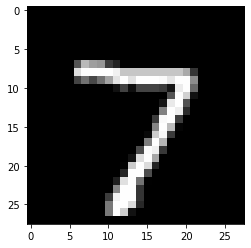

adv


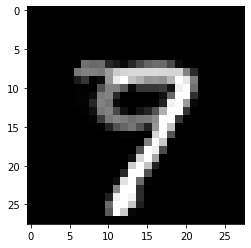

In [ ]:
i = 0
print('clean')
plt.imshow(x_test[i].detach().reshape(28, 28), cmap='gray')
plt.show()
print('adv')
plt.imshow(x_adv[i].detach().reshape(28, 28), cmap='gray')
plt.show()